In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os
import glob

from datetime import timedelta, datetime
from dateutil.relativedelta import relativedelta

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
%matplotlib inline

## Analytics - Part2 (Customer Segmentation)
- RFM
- Elbow method & Silhouette score
- Kmeans
- Visualization of Clusters


*******************************************************************************************************************************************************************
### RFM Segmentation
- RFM segmentation refers to a common method used for customer segmentation based on the concepts of Recency, Frequency, and Monetary Value. RFM analysis is widely used in marketing and customer analytics to identify and group customers based on their purchasing behavior. Additionally, I will use an extra feature, which is the number of unique categories that each customer bought. So, basically, RFM + $\alpha$ method will be applied for the customer segmentation in the following section.

### Load data

In [33]:
features = ['customer_unique_id', 'order_id', 'order_status', 'product_category_name', 'order_purchase_timestamp', 'payment_value']
df = pd.read_csv("./datasets/olist_master.csv")
df = df[features]
print(df.isna().sum())
print()
print(df.shape)

customer_unique_id          0
order_id                    0
order_status                0
product_category_name       0
order_purchase_timestamp    0
payment_value               0
dtype: int64

(116581, 6)


### Preprocessing & RFM + $\alpha$ Analysis

In [34]:
#preprocessing
df = df[df.order_status == 'delivered'].reset_index(drop=True)
df.order_purchase_timestamp = df.order_purchase_timestamp.str.slice(0,10)
df['created_at'] = df.order_purchase_timestamp.apply(lambda x: pd.to_datetime(x, format = "%Y-%m-%d"))
df.drop_duplicates(inplace=True)
df.head()

,customer_unique_id,order_id,order_status,product_category_name,order_purchase_timestamp,payment_value,created_at
0,5ee8fe956c2631afc0a1dcc1920d0e3d,00010242fe8c5a6d1ba2dd792cb16214,delivered,Cool Stuff,2017-09-13,72.19,2017-09-13
1,8b3f917f4307d3e5cf34c0b43d6e6f50,130898c0987d1801452a8ed92a670612,delivered,Cool Stuff,2017-06-28,73.86,2017-06-28
2,69ba88e17ea574da9c9b8c8834a583d1,532ed5e14e24ae1f0d735b91524b98b9,delivered,Cool Stuff,2018-05-18,83.23,2018-05-18
3,cbe063493a222cb17024ff0285b4ecb6,6f8c31653edb8c83e1a739408b5ff750,delivered,Cool Stuff,2017-08-01,75.07,2017-08-01
4,ffab5330bd7b40979ab6726b2e02292e,7d19f4ef4d04461989632411b7e588b9,delivered,Cool Stuff,2017-08-10,72.19,2017-08-10


In [77]:
#rfm + number of categories
class calculate_rfm():
    def __init__(self, df):
        self.df = df 
        self.df.created_at = pd.to_datetime(self.df.created_at)
        
    def calculate_rfm_modified(self):        
        data = df.sort_values(by=['customer_unique_id', 'created_at'])
        # frequency
        df_tmp = data[['customer_unique_id', 'created_at']].copy().drop_duplicates()
        df_tmp['rn'] = df_tmp.groupby('customer_unique_id')['created_at'].cumcount() + 1 
        df_tmp['rn_idx'] = df_tmp.rn - 1
        df_freq_tmp = pd.merge(df_tmp, df_tmp,
                               left_on=['customer_unique_id', 'rn'],
                               right_on=['customer_unique_id', 'rn_idx'],
                               how='left')
        df_freq_tmp['frequency'] = (df_freq_tmp.created_at_y - df_freq_tmp.created_at_x).dt.days
        df_rfm = df_freq_tmp.groupby('customer_unique_id', as_index=False).frequency.mean().fillna(0)
        
        # order_count, monetary, nproduct
        df_rfm = pd.merge(df_rfm,
                          data.groupby('customer_unique_id', as_index=False).agg(orders=('order_id', 'count'),
                                                                          monetary=('payment_value', 'sum'),
                                                                          n_categories=('product_category_name', 'nunique')),
                          on='customer_unique_id',
                          how='left')
        
        # recency
        df_rfm = pd.merge(df_rfm, 
                          data.groupby('customer_unique_id', as_index=False).agg(recency=('created_at', 'max')),
                          on = 'customer_unique_id',
                          how = 'left')
        df_rfm['recency'] = (data.created_at.max() - df_rfm.recency).dt.days
        
        df_rfm = df_rfm.set_index('customer_unique_id')
        
        return df_rfm
    
    def viz_rfm(self, rfm):
        plt.figure(figsize = (16, 14))
        
        plt.subplot(4,1,1)
        sns.distplot(rfm.recency)
        # plt.title("Distribution of Recency")

        plt.subplot(4,1,2)
        sns.distplot(rfm.frequency)
        # plt.title('Distribution of Frequency')

        plt.subplot(4,1,3)
        sns.distplot(rfm.monetary)
        # plt.title("Distribution of Monetary")

        plt.subplot(4,1,4)
        sns.distplot(rfm.n_categories)
        # plt.title('Distribution of number of categories bought')

        plt.show()

In [78]:
rfm_class = calculate_rfm(df)
df_rfm = rfm_class.calculate_rfm_modified()

In [79]:
df_rfm.head()

,frequency,orders,monetary,n_categories,recency
customer_unique_id,,,,,
0000b849f77a49e4a4ce2b2a4ca5be3f,111.0,2,136.26,2,169
0000f46a3911fa3c0805444483337064,134.0,3,583.87,3,125
0004bd2a26a76fe21f786e4fbd80607f,218.5,3,336.11,3,7
00050ab1314c0e55a6ca13cf7181fecf,0.0,1,80.18,1,219
0005ef4cd20d2893f0d9fbd94d3c0d97,0.0,1,187.91,1,481


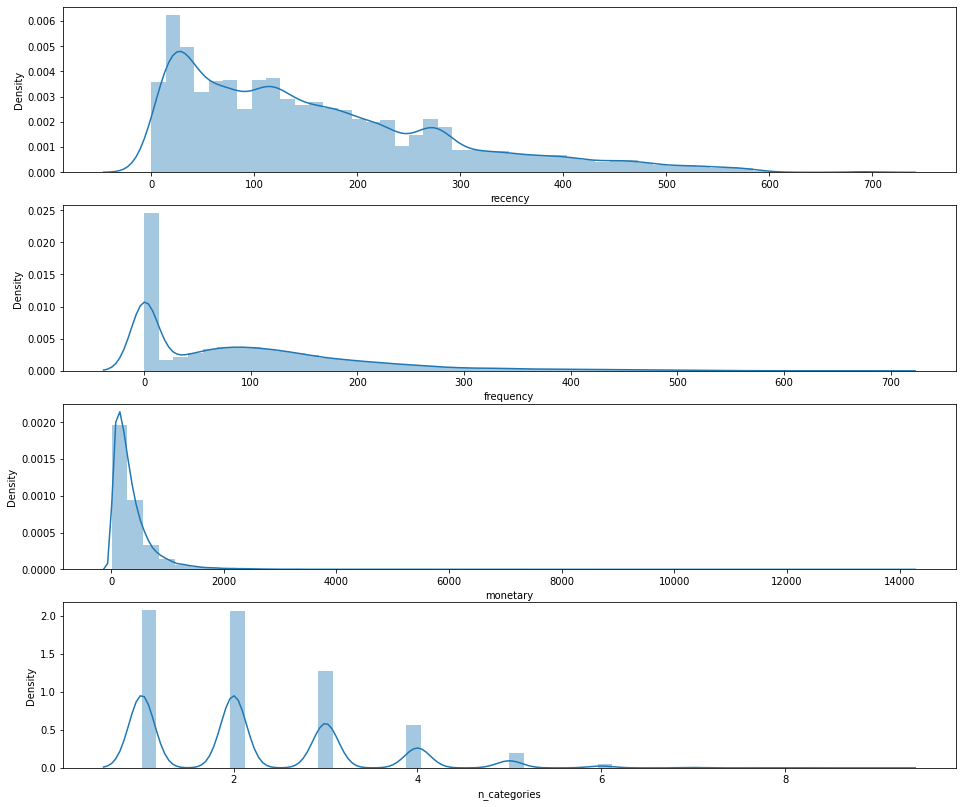

In [80]:
rfm_class.viz_rfm(df_rfm)

### Segmentation